## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from pprint import pprint

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score,precision_score,recall_score

### 1.  Data loading

In [4]:
!conda install -y gdown

import gdown

url = 'https://drive.google.com/file/d/1CFNwjaGpglIjmqhW9hQ0FPmvFzSRWLCv'

output = 'file.zip'

gdown.download(url, output, quiet=False)

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.9.0             |     pyhd8ed1ab_0          13 KB  conda-forge
    gdown-4.6.2                |     pyhd8ed1ab_0          18 KB  conda-forge
    openssl-1.1.1t             |       h0b41bf4_0         1.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.9 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.9.0-pyhd8ed1ab_0 None
  gdown              conda-forge/noarch::gdown-4.6.2-pyhd8ed1

/opt/conda/lib/python3.7/site-packages/gdown/parse_url.py:39: UserWarning:

You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None

Downloading...
From: https://drive.google.com/file/d/1CFNwjaGpglIjmqhW9hQ0FPmvFzSRWLCv
To: /kaggle/working/file.zip
70.7kB [00:00, 32.8MB/s]


'file.zip'

In [5]:
!gdown --id 1CFNwjaGpglIjmqhW9hQ0FPmvFzSRWLCv

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CFNwjaGpglIjmqhW9hQ0FPmvFzSRWLCv
To: /kaggle/working/complaints-2021-05-14_08_16.json
100%|███████████████████████████████████████| 83.4M/83.4M [00:00<00:00, 148MB/s]


In [6]:
import os
os.listdir()

['complaints-2021-05-14_08_16.json',
 '.virtual_documents',
 '__notebook_source__.ipynb',
 'file.zip']

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
# Opening JSON file 
with open('complaints-2021-05-14_08_16.json', 'r') as f:
    data = json.load(f)
df=pd.json_normalize(data)
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


## Data preparation

In [8]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign new column names

df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]

df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df[['complaint_text','category','sub_category']].head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [11]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_text'] ==''] = np.nan
df.complaint_text.isnull().sum()

57241

In [12]:
#Remove all rows where complaints column is nan
df = df[~df.complaint_text.isnull()]
df.complaint_text.isnull().sum()

0

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text)  # Remove words containing numbers
    return text.strip()

In [14]:
df.complaint_text.head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint_text, dtype: object

In [15]:
df.complaint_text = df.complaint_text.apply(lambda x: clean_text(x))
df.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

In [16]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words

def lemmatizer(text):
    doc = nlp(text)
    lemmatized_output = ' '.join([token.lemma_ for token in doc if not token.text in set(stopwords)])
    return lemmatized_output

In [17]:
df['lemmatized_complaint'] =  df.complaint_text.apply(lambda x: lemmatizer(x))
df.head(5)

,complaint_text,category,sub_category,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,Debt collection,Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card,General-purpose credit card or charge card,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",Credit reporting,try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account,Checking account,grand son check deposit chase account fund cle...


In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_text','lemmatized_complaint']]
df_clean.head()

,complaint_text,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...


In [19]:
#Write your function to extract the POS tags 
nlp = en_core_web_sm.load()

def extract_pos_tags(text):
    doc = nlp(text)
    tag_nn = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(tag_nn)

df_clean["complaint_POS_removed"] = df_clean.lemmatized_complaint.apply(lambda x: extract_pos_tags(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,account pay money son money money check owner ...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call cha xxxx xxxx visa cre...,credit card provider ask claim purchase purcha...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,risk consumer trust banking tell deal merchant...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ve chase credit card chas...,credit credit card freedom problem life experi...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0, 0.5, 'No. of Complaints')

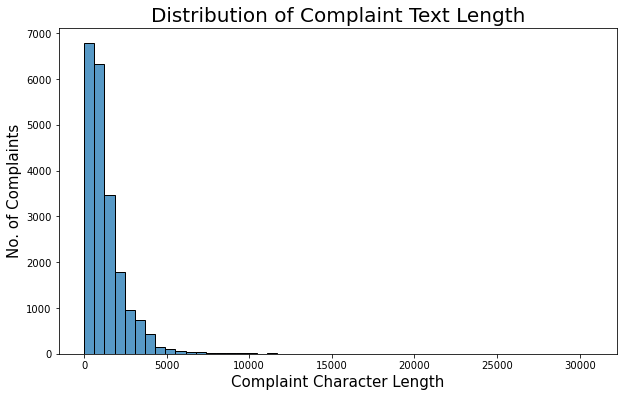

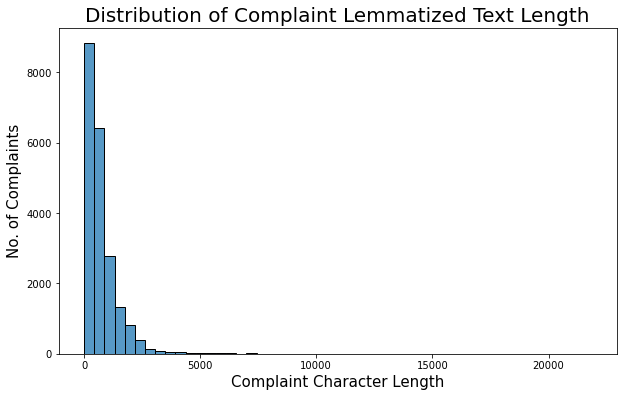

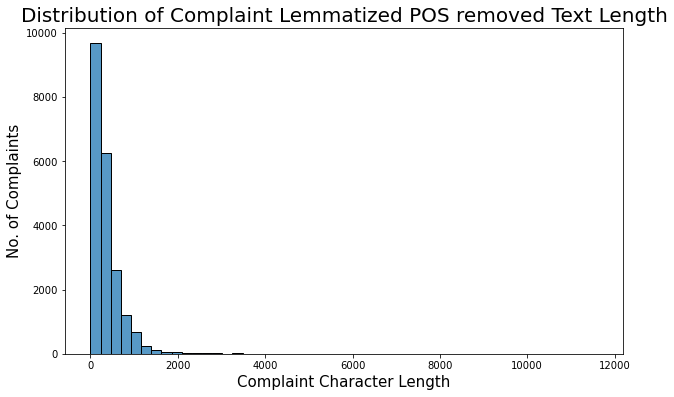

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length

char_len=[len(x) for x in df_clean['complaint_text']]

plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Text Length', fontsize=20)
plt.xlabel('Complaint Character Length',size=15)
plt.ylabel('No. of Complaints',size=15)


char_len=[len(x) for x in df_clean['lemmatized_complaint']]

plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Lemmatized Text Length', fontsize=20)
plt.xlabel('Complaint Character Length',size=15)
plt.ylabel('No. of Complaints',size=15)


char_len=[len(x) for x in df_clean['complaint_POS_removed']]

plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Lemmatized POS removed Text Length', fontsize=20)
plt.xlabel('Complaint Character Length',size=15)
plt.ylabel('No. of Complaints',size=15)

#### Find the top 40 words by frequency among all the articles after processing the text.

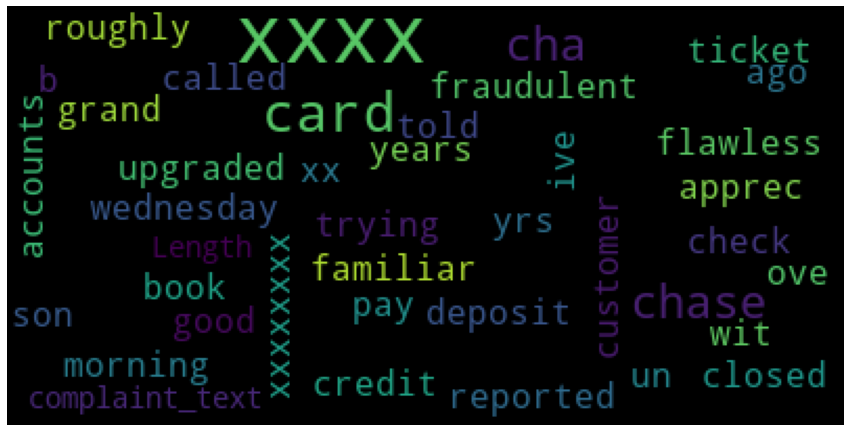

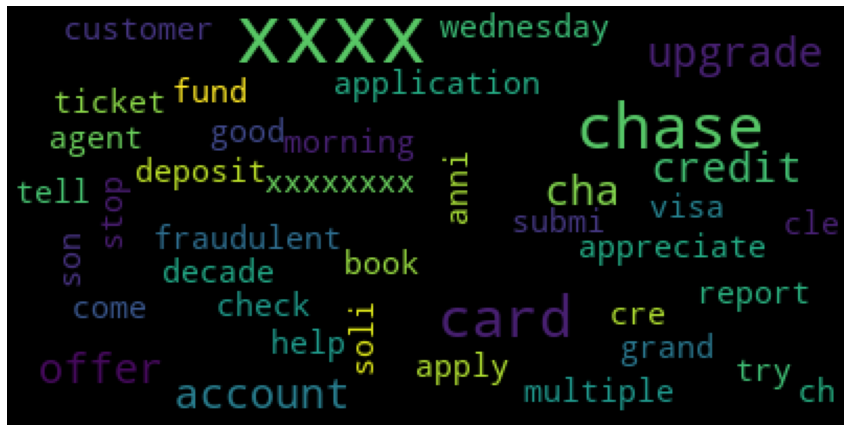

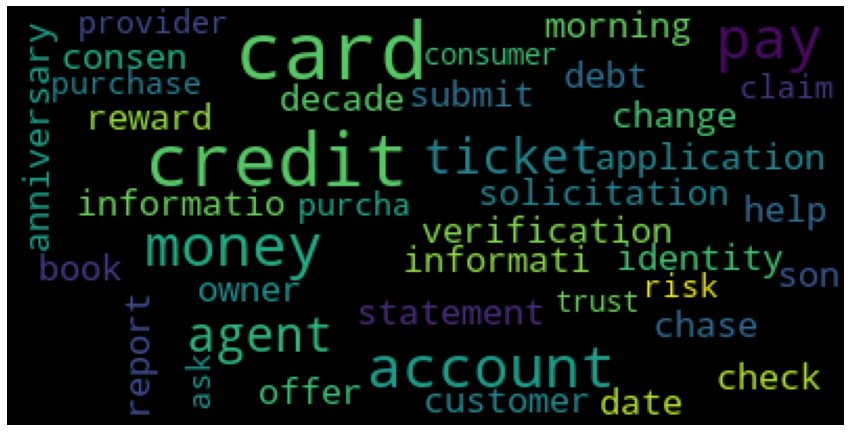

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
word_cloud = WordCloud(
                          stopwords=stopwords,
                          max_font_size=38,
                          max_words=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_text']))

fig = plt.figure(figsize=(15,12))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


word_cloud = WordCloud(
                          stopwords=stopwords,
                          max_font_size=38,
                          max_words=40, 
                          random_state=42
                         ).generate(str(df_clean['lemmatized_complaint']))

fig = plt.figure(figsize=(15,12))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


word_cloud = WordCloud(
                          stopwords=stopwords,
                          max_font_size=38,
                          max_words=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(15,12))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [23]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application submit identity consen...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,account pay money son money money check owner ...,account pay money son money money check owner ...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:
# Top n bigram function
def get_top_n_gram(text,ngram=1, n=None):

    vector = CountVectorizer(ngram_range=(ngram,ngram),stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [25]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_unigrams = get_top_n_gram(df_clean.Complaint_clean,ngram=1, n=30)

In [26]:
#Print the top 10 words in the unigram frequency
print('Top 10 words in unigram frequency - ')
top_30_unigrams[:10]

Top 10 words in unigram frequency - 


[('account', 38141),
 ('credit', 31612),
 ('card', 29121),
 ('chase', 21532),
 ('payment', 20007),
 ('charge', 15653),
 ('time', 14205),
 ('bank', 11688),
 ('money', 11670),
 ('check', 11354)]

In [27]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_top_n_gram(df_clean.Complaint_clean,ngram=2, n=30)

In [28]:
#Print the top 10 words in the bigram frequency
print('Top 10 words in bigram frequency - ')
top_30_bigrams[:10]

Top 10 words in bigram frequency - 


[('credit card', 12318),
 ('credit report', 3250),
 ('customer service', 2897),
 ('check account', 2483),
 ('debit card', 1875),
 ('account account', 1688),
 ('card account', 1599),
 ('credit score', 1597),
 ('bank account', 1432),
 ('payment payment', 1314)]

In [29]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = get_top_n_gram(df_clean.Complaint_clean,ngram=3, n=30)

In [30]:
#Print the top 10 words in the trigram frequency
top_30_trigrams[:10]

[('credit card account', 1038),
 ('credit card company', 980),
 ('chase credit card', 870),
 ('charge credit card', 583),
 ('credit card credit', 500),
 ('credit card chase', 449),
 ('inquiry credit report', 443),
 ('card credit card', 412),
 ('account credit card', 396),
 ('file police report', 356)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [32]:
#All masked texts has been removed
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application submit identity consen...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,account pay money son money money check owner ...,account pay money son money money check owner ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call cha xxxx xxxx visa cre...,credit card provider ask claim purchase purcha...,credit card provider ask claim purchase purcha...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,risk consumer trust banking tell deal merchant...,risk consumer trust banking tell deal merchant...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ve chase credit card chas...,credit credit card freedom problem life experi...,credit credit card freedom problem life experi...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
#Write your code here to initialise the TfidfVectorizer 

tf_idf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tf_idf.fit_transform(df_clean['Complaint_clean'])

tf_idf.get_feature_names()[:10]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['aa',
 'aarp',
 'abandonment',
 'abatement',
 'abbreviation',
 'abd',
 'aberrant',
 'abhorrent',
 'abide',
 'ability']

In [35]:
len(tf_idf.get_feature_names())

6141

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [36]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)


In [38]:
nmf_model.fit(dtm)
len(tf_idf.get_feature_names())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



6141

In [39]:
#Print the Top15 words for each of the topics
import numpy as np
words = np.array(tf_idf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,deposit,fund,branch,day,transfer,number,chase,transaction,business,claim,customer
Topic 2,credit,card,report,inquiry,account,chase,score,company,information,limit,application,debt,letter,year,balance
Topic 3,payment,balance,pay,month,statement,fee,day,auto,time,date,credit,year,chase,error,account
Topic 4,charge,dispute,fee,card,transaction,merchant,purchase,claim,refund,chase,fraud,service,balance,email,statement
Topic 5,loan,mortgage,home,modification,property,document,request,rate,chase,foreclosure,year,time,letter,sale,information


In [40]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([4, 0, 1, ..., 3, 2, 2])

In [41]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)

In [42]:
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...,4
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application submit identity consen...,card report application submit identity consen...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,account pay money son money money check owner ...,account pay money son money money check owner ...,0


In [43]:
#Print the frst 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus c...,account deposit bonus pay deposit account coup...,account deposit bonus pay deposit account coup...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...,0
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,account pay money son money money check owner ...,account pay money son money money check owner ...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,restrict account debit card go branch customer...,restrict account debit card go branch customer...,0
35,i opened the saving account for the bonus i wa...,open saving account bonus suppose received bon...,account bonus bonus auto transfer check notice...,account bonus bonus auto transfer check notice...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application submit identity consen...,card report application submit identity consen...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,1
15,can you please remove inquiry,remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,credit card credit report company issue,credit card credit report company issue,1
26,i have reached out to xxxx several times in at...,reach xxxx time attempt fraudulent inquiry rem...,time attempt inquiry remove contact creditor i...,time attempt inquiry remove contact creditor i...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [44]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [45]:
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...,Bank Account services
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application submit identity consen...,card report application submit identity consen...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,account pay money son money money check owner ...,account pay money son money money check owner ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call cha xxxx xxxx visa cre...,credit card provider ask claim purchase purcha...,credit card provider ask claim purchase purcha...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,risk consumer trust banking tell deal merchant...,risk consumer trust banking tell deal merchant...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ve chase credit card chas...,credit credit card freedom problem life experi...,credit credit card freedom problem life experi...,Others


<AxesSubplot:xlabel='Topic', ylabel='count'>

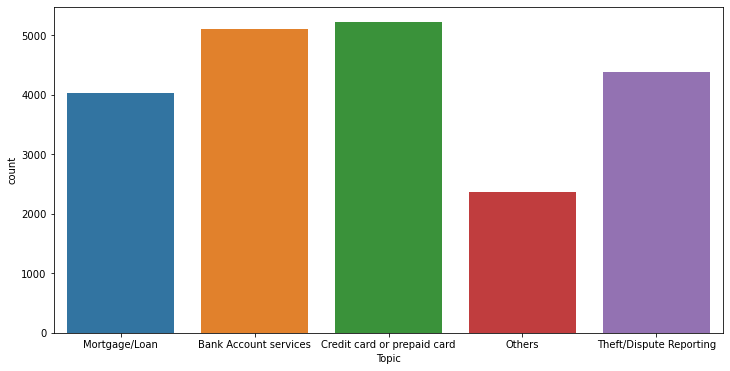

In [46]:
plt.figure(figsize=(12,6))
sns.countplot(x='Topic', data=df_clean)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [47]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank Account services' : 0,
    'Credit card or prepaid card' : 1,
    'Others' : 2,
    'Theft/Dispute Reporting' : 3,
    'Mortgage/Loan' : 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...,4
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application submit identity consen...,card report application submit identity consen...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,account pay money son money money check owner ...,account pay money son money money check owner ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call cha xxxx xxxx visa cre...,credit card provider ask claim purchase purcha...,credit card provider ask claim purchase purcha...,3
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,risk consumer trust banking tell deal merchant...,risk consumer trust banking tell deal merchant...,3
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ve chase credit card chas...,credit credit card freedom problem life experi...,credit credit card freedom problem life experi...,2


In [49]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data =  df_clean[['complaint_text','Topic']]

In [50]:
training_data

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told b...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i...,1
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had cha...,2


Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [51]:
# x - y  split
X = training_data.complaint_text
y = training_data.Topic

In [52]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [53]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.27, random_state=40, stratify=y)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [54]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report



In [55]:
# Create a function to evaluate models
def model_eval(model, model_name):
    
    result = []
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(model_name, 'details - \n')
    # print best hyperparameters
    print("Best AUC: ", model.best_score_)
    print("Best hyperparameters: ", model.best_params_)
    print('\n')
    
    #accuracy score 
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    print("Accuracy score for Train:", acc_score_train)
    print("Accuracy score for Test:", acc_score_test)
    print('\n')
    
    # F1 score
    f1score_train = round(f1_score(y_train, y_train_pred, average="weighted"),2)
    f1score_test = round(f1_score(y_test, y_test_pred, average="weighted"),2)
    print("F1-score for Train:", f1score_train)
    print("F1-score for Test:", f1score_test)
    print('\n')
    
    # print classification report of classifier
    print(f"Classification Report for Train")
    print(classification_report(y_train, y_train_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    print(f"Classification Report for Test")
    print(classification_report(y_test, y_test_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # confusion matrix of the classifier
    print("Confusion Matrix for Train \n")
    print(confusion_matrix(y_train, y_train_pred),'\n')
    
    print("Confusion Matrix for Test \n")
    print(confusion_matrix(y_test, y_test_pred))
    
    precision = round(precision_score(y_test, y_test_pred,average='micro'),2)
    recall = round(recall_score(y_test, y_test_pred,average='micro'),2)
    
    result.append(acc_score_train)
    result.append(acc_score_test)
    result.append(f1score_train)
    result.append(f1score_test)
    result.append(precision)
    result.append(recall)
    
    
    return result

In [56]:

def grid_search(estimator,param_grid,scoring,cv):
    
    grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           verbose=1,
                           scoring=scoring,
                           n_jobs=-1,
                           cv=cv)
    return grid_search

**1.Logistic Regression**

In [57]:
# Hyperparameter tuning for best result
model_name ='Logistic Regression'
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 4)

lr = LogisticRegression()
lr_model = grid_search(lr,param_lr,'f1_weighted',folds)

In [58]:
# fit model
lr_model.fit(X_train, y_train)

# Evaluate the model
result_lr = model_eval(lr_model, model_name) 

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


54 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solv

Logistic Regression details - 

Best AUC:  0.9180318938226315
Best hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


Accuracy score for Train: 0.93
Accuracy score for Test: 0.92


F1-score for Train: 0.93
F1-score for Test: 0.92


Classification Report for Train
                             precision    recall  f1-score   support

      Bank Account services       0.93      0.94      0.93      3719
Credit card or prepaid card       0.94      0.95      0.94      3807
                     Others       0.94      0.91      0.93      1721
    Theft/Dispute Reporting       0.93      0.91      0.92      3197
              Mortgage/Loan       0.93      0.94      0.94      2938

                   accuracy                           0.93     15382
                  macro avg       0.93      0.93      0.93     15382
               weighted avg       0.93      0.93      0.93     15382

Classification Report for Test
                             precision    recall  f1-score   support

**2.Decision Tree**

In [59]:
# Hyperparameter tuning for best result
model_name ='Decision Tree'
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

dt = DecisionTreeClassifier()
dt_model = grid_search(dt,param_dt,'f1_weighted',folds)

In [60]:
# fit model
dt_model.fit(X_train, y_train)

# Evaluate the model
result_dt = model_eval(dt_model, model_name)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Decision Tree details - 

Best AUC:  0.7893890273294147
Best hyperparameters:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 20}


Accuracy score for Train: 0.84
Accuracy score for Test: 0.79


F1-score for Train: 0.84
F1-score for Test: 0.79


Classification Report for Train
                             precision    recall  f1-score   support

      Bank Account services       0.84      0.86      0.85      3719
Credit card or prepaid card       0.86      0.87      0.87      3807
                     Others       0.84      0.81      0.83      1721
    Theft/Dispute Reporting       0.82      0.79      0.80      3197
              Mortgage/Loan       0.83      0.86      0.84      2938

                   accuracy                           0.84     15382
                  macro avg       0.84      0.84      0.84     15382
               weighted avg       0.84      0.84      0.84     15382

Classification Report fo

In [61]:
result_lr

[0.93, 0.92, 0.93, 0.92, 0.92, 0.92]

In [62]:
dict = {'Model':['Accuracy Train','Accuracy Test','F1-score Train','F1-score Test'],
        'Logistic Regression':[result_lr[0], result_lr[1],result_lr[2],result_lr[3]],
        'Decision Tree':[result_dt[0],result_dt[1],result_dt[2],result_dt[3]]
       }

In [63]:
results_df = pd.DataFrame(dict)
results_df

,Model,Logistic Regression,Decision Tree
0,Accuracy Train,0.93,0.84
1,Accuracy Test,0.92,0.79
2,F1-score Train,0.93,0.84
3,F1-score Test,0.92,0.79


**3.Random Forest**


In [70]:
# Hyperparameter tuning for best result
model_name ='Random Forest'
param_rf = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

count_class_1 = y_train.value_counts()[0]
count_class_2 = y_train.value_counts()[1]
ratio = count_class_1/count_class_2

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)
rf = RandomForestClassifier(class_weight={1:ratio, 0:1}, 
                                       n_jobs = -1,
                                       min_samples_leaf=100, 
                                       min_samples_split=200,
                                       n_estimators=100,oob_score=True)

rf_model = grid_search(rf,param_rf,'roc_auc',folds)

In [71]:
# fit model
rf_model.fit(X_train, y_train)

# Evaluate the model
result_rf = model_eval(rf_model, model_name)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The

Random Forest details - 

Best AUC:  nan
Best hyperparameters:  {'criterion': 'gini', 'max_features': 'auto'}


Accuracy score for Train: 0.71
Accuracy score for Test: 0.69


F1-score for Train: 0.67
F1-score for Test: 0.65


Classification Report for Train
                             precision    recall  f1-score   support

      Bank Account services       0.69      0.89      0.78      3719
Credit card or prepaid card       0.61      0.88      0.72      3807
                     Others       1.00      0.00      0.00      1721
    Theft/Dispute Reporting       0.84      0.66      0.74      3197
              Mortgage/Loan       0.83      0.72      0.77      2938

                   accuracy                           0.71     15382
                  macro avg       0.80      0.63      0.60     15382
               weighted avg       0.76      0.71      0.67     15382

Classification Report for Test
                             precision    recall  f1-score   support

      Bank Accoun

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/c